In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [3]:
import sunradiation as sun
import weatherfeed as wf
import emoncmsfeed as getfeeds

# Modélisation thermique type "boite grise" de mon appartement

**L'idée du projet** est d'évaluer les propriétés thermiques de mon appartement (masse thermique, isolation et ombrage) grâce à un modèle simple type "boite grisse". Les coefficients sont ajustés en prennant en compte la météo et la mesure de la température intérieure. 

L'intêret d'un tel modèle serait d'évaluer l'impact de modifications dans l'appartement sur son comportement thermique. Par exemple, est-ce que l'ajout du rideau permet réellement de garder la fraicheur en été ? 

Le modèle doit pouvoir, en prennant en compte la météo, permetre de comparer les valeurs obtenues de jours en jours, sans avoir à se soucier de savoir si tel jour était plus chaud qu'un autre, par exemple.

** Source des données. **
Je mesure et enregistre la température intérieure de mon appartement avec le système proposé par [Open Energy Monitor](https://openenergymonitor.org/). C'est un Raspberry Pi qui log la température intérieure toutes les minutes (moyennées ensuite à 15 min). 


Les données météo sont disponible avec une API sur [darksky.net](https://darksky.net/dev/docs).


#### Le modèle

L'idée est de commencer par un modèle très simple. La température de l'appartement est principalement fonction de la **température extérieure** et de **l'irradiation solaire**. Il y a donc deux coefficients à determiner: la résistance thermique  avec l'extérieure -notée $h$ en W/K-, et la part du flux de chaleur qui chauffe l'appartement -noté $\eta$, pourcentage-.

Il y a un troisiéme coefficient qui est la masse thermique globale de l'appartement: $M$, en J/K. Ce coefficient est le rapport entre l'énergie fournie et la variation de température induite. 

 
Le schéma électrique équivalent est :
![schéma eq.](images/sch_blackbox02.png)

et l'équation différentielle correspondante est :
$$
 \frac{dT}{dt} = \frac{h}{M} \,\Big( T_{ext}(t) - T \Big) + \frac{\eta}{M} \, \Phi(t)
$$

On voit que la masse thermique apparait pour les deux termes du modèle. Il ne sera donc pas possible de la déterminer avec ce modèle. 

En été, l'isolation (h) et le masquage du rayonement solaire ($\eta$) dépend fortement de l'aération (ouverture des fenêtres la nuit) et de l'utilisation des rideaux la journée. Ces deux coefficients ne sont donc pas constant mais varie suivant l'usage de l'appartement.

Pour le moment, on va s'intérésser aux données obtenues pendant une semaine de vacances en été. Je n'étais pas chez moi, et donc l'isolation, et le masquage des fenêtres sont, à priori, restés constant pendant cette semaine. 


L'objectif est de voir si ce modèle simple peut décrire la thermique de l'appartement et si on obtient des valeurs cohérentes pour ces deux coefficients. 

#### Plan d'attaque:

1. Chargement de données météo  et mesures
2. Création du modèle, et test
3. Estimation des paramètres par optimisation
4. Vérification des ordres de grandeurs des valeurs obtenues

# 1. Chargement des données

Le chargements des données est effectuée dans le [notebook testweek_get_data](testweek_get_data.ipynb).  
Pickle est utilisé pour transférer les données, et les charger dans un dataframe (Pandas). 

In [6]:
df  = pd.read_pickle( 'weektest_data.pck' )
print( ', '.join(df.columns) )

cloudCover, humidity, precipIntensity, temperature, windBearing, windGust, windSpeed, flux_tot, T_int


Les colones qui nous intéresse ici sont la **température intérieure** mesurée `T_int`, la **température extérieure** `temperature` et **flux de chaleur sur les vitres** `flux_tot`: 

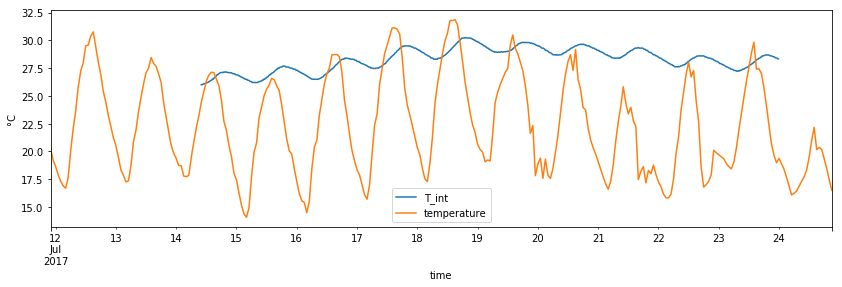

In [7]:
df[['T_int', 'temperature']].plot( figsize=(14, 4) ); plt.ylabel('°C');

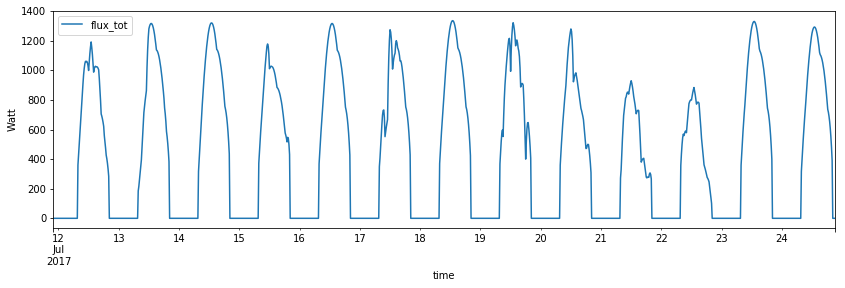

In [8]:
# Flux solaire sur les vitres:
df[['flux_tot']].plot( figsize=(14, 4) ); plt.ylabel('Watt');

# 2. Résolution du modèle

L'équation différentielle est résolue simplement avec `odeint` de _scipy_ ([doc](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.odeint.html)).

In [9]:
from scipy.integrate import odeint

In [10]:
def get_dTdt(  T, t, params, get_Text, get_Phi ):
    """ dérivé de la température par rapport au temps
        params :   [ h/M  ,  eta/M ]
        get_Text, get_Phi : fonctions d'interpolation 
    """
    
    T_ext  = get_Text( t )
    phi = get_Phi( t ) 
    
    dTdt = params[0] * ( T_ext - T ) + params[1] / 100 * phi
    
    return 1e-6*dTdt


def apply_model( data, params, full_output=False, fasttol=True ):

    rtol, atol = 1e-8, 1e-8
    if fasttol:
        rtol, atol = 1e-3, 1e-4
        
    data_dict = data.to_dict(orient='list')
    time_sec = data.index.astype(np.int64) // 1e9    # conversion en seconde

    # Construction des fonctions d'interpolations: 
    get_Text = lambda t: np.interp( t, time_sec, data_dict['temperature'] )
    get_Phi  = lambda t: np.interp( t, time_sec, data_dict['flux_tot'] )

    T_start = params[2]
    params_eqdiff = params[0:2]
    T_theo = odeint(get_dTdt, T_start, time_sec, args=(params_eqdiff, get_Text, get_Phi  ), \
                full_output=full_output, h0=30*60, col_deriv=True, rtol=rtol, atol=atol)
    # h0 : pas de temps initial utilisé par le solveur
    
    return T_theo.flatten()

In [13]:
# - test du modèle -
Tzero = df['T_int'].mean()
params =  ( 4, 5, Tzero ) # paramètres:  k/M, 100*eta/M, T( t=0 )

T_theo = apply_model( df, params )

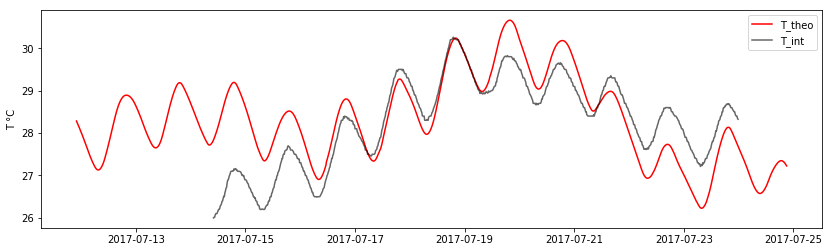

In [14]:
# graph
plt.figure( figsize=(14, 4) )
plt.plot( df.index, T_theo, 'r', label='T_theo')
plt.plot( df['T_int'], 'k', alpha=0.6) ;
plt.legend(); plt.ylabel('T °C');

# 3. Evaluation des paramètres

On utilise la fonction d'optimisation `minimize` de scipy ([doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)).

In [15]:
from scipy.optimize import minimize

In [16]:
def get_errorfit( params, data ):
    """ Applique le modèle pour les données et les paramètres
        puis calcul l'erreur avec les données expérimentals (en ignorant les NaN)
    """
    T_theo = apply_model( data, params )
        
    T_exp = data['T_int'].as_matrix()
    delta = (T_exp - T_theo)**2
    
    return np.sum( delta[  ~np.isnan( delta ) ] )

In [17]:
# - test -
get_errorfit( params, df )

581.37606584951459

In [18]:
# calcul de l'optimisation : 
params_depart = ( 4, 3, 24 )

opti_res = minimize(get_errorfit, params_depart, args=(df), method='Nelder-Mead')
print( opti_res )

 final_simplex: (array([[  2.69612635,   3.96428255,  24.327471  ],
       [  2.69612635,   3.96428255,  24.327471  ],
       [  2.69612635,   3.96428255,  24.327471  ],
       [  2.69612635,   3.96428255,  24.327471  ]]), array([ 62.91820768,  62.91820783,  62.91820783,  62.91820785]))
           fun: 62.918207679881228
       message: 'Optimization terminated successfully.'
          nfev: 255
           nit: 108
        status: 0
       success: True
             x: array([  2.69612635,   3.96428255,  24.327471  ])


** Remarque: test des autres algorithmes **   
CG:       fun: 535.06824907818589   
Nelder-Mead (simplex) : fun: 65.792436955967446   << (2.5, 3, 27 )  
Nelder-Mead (simplex) : fun: 62.918207679881228   << ( 4, 3, 24 )   
Powel :  fun: 214.19465163136513  

In [19]:
# Calcul du modèle avec les paramètres obtenus :
T_theo = apply_model( df, opti_res.x, fasttol=False )

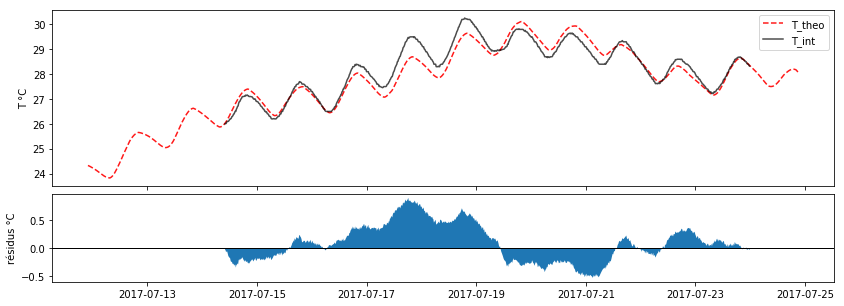

In [20]:
# graph
fig, ax = plt.subplots(2, sharex=True, figsize=(14, 5), gridspec_kw = {'height_ratios':[2, 1]} )

ax[0].plot( df.index, T_theo, '--r', label='T_theo', alpha=0.9)
ax[0].plot( df['T_int'], 'k', alpha=0.7) ;
ax[0].legend(); ax[0].set_ylabel('T °C');

ax[1].fill_between( df.index,  df['T_int'].as_matrix()-T_theo, 0 ) ;
ax[1].axhline(y=0., color='k', linestyle='-', linewidth=1); ax[1].set_ylabel('résidus °C');

plt.subplots_adjust(hspace=0.06)

In [37]:
print(  ' h/M = %.3f *1e-6 sec-1  \n eta/M = %.3f *1e-6 K/J   \n T0 = %.1f °C' %tuple(opti_res.x) )

 h/M = 2.696 *1e-6 sec-1  
 eta/M = 3.964 *1e-6 K/J   
 T0 = 24.3 °C


In [39]:
h_M_opti = opti_res.x[0]*1e-6
eta_M_opt = opti_res.x[1]*1e-6

# 4. Vérification des ordres de grandeur

### Masse thermique

In [38]:
# pour le béton :
rhoCp = 2000e3 # J/m3/K
k = 1.75       # W/m/K
D = k/rhoCp    # diffusivité

# distance caractéristique pour une certaine période 
temps_carac = 60*60*12 # s, 12h 
distance = np.sqrt( D*temps_carac  )

surface_murs = 58 + 2*22.7  # m2

M_mur = surface_murs*distance*rhoCp

print( 'distance carac ~ %.0f cm'% (distance * 100) )
print( 'masse thermique ~ %.1e J/K' % M_mur )

distance carac ~ 19 cm
masse thermique ~ 4.0e+07 J/K


La masse thermique de ~ 20cm de béton est donc d'environ ~ 4e7 W/K.  Ceci doit être la valeur maximale, mon appartement étant sous les toits, 20cm est l'épaisseur des murs et de la dalle. 

Rq: La masse thermique de l'air est ~ 1000 W/K.

### Isolation


In [30]:
h_vitre = 2.8 # W/m2/K   - double vitrage simple
surface_vitres = 0.6*0.8*2 + 1.2*0.8 + 0.3*0.72*4 + 0.25**2 # m2 
U_vitres = h_vitre * surface_vitres

longueur_cadres = (0.6+0.8)*4 + (1.2+0.8)*2 + 2*(0.3+0.72)*4 + 4*0.25

psi = 0.016
k_bois = 0.15 + psi #  
U_cadres = k_bois*longueur_cadres # W/K

h_theo = U_vitres + U_cadres
print( 'surface vitrage = %.0f m2'% (surface_vitres) )
print( 'h_theo ~ %.1f W/K (%i%% cadres)'%( h_theo, 100*U_cadres/h_theo ) )

surface vitrage = 3 m2
h_theo ~ 11.1 W/K (28% cadres)


Les autres sources possibles sont :    
* L'isolation du toit : h_toit ~ 0.5 W/K
* Aération naturelle  h_aera ~ 0.6W/K ... ?
* Avec une ventilation : h ~ 600W/K

#### estimation de la masse thermique ...

In [31]:
eta_max = 100 # %
M_max =  eta_max  / eta_M_opt
print( 'M max  : %.3e J/K'%M_max )

M max  : 2.523e+07 J/K


In [40]:
# estimation de la masse thermique  à partir de l'isolation théorique
M_esti = h_theo / h_M_opti

print( 'Masse thermique déduite ~ %.1e J/K'%M_esti )

Masse thermique déduite ~ 4.1e+06 J/K


On trouve donc un facteur 10 entre la masse thermique de ~20cm de béton et celle estimée à partir des données. Cela correspond donc plutôt à 2 cm de béton ...

In [42]:
# Déduction de la valeur de eta :
eta_esti =  eta_M_opt * M_esti
print( 'eta déduit ~ %.0f %%'%eta_esti )

eta déduit ~ 16 %


La valeur obtenue de $\eta$ est assez cohérente. Toutes les vitres avaient des rideaux ocultants pendant cette période. 

### Pour la suite
* partir en vacances plus longtemps ...
* Modèle avec deux masses thermique ? ou la résistance air-mur ? ou continu dans l'épaisseur du mur ?
* faire les fits en période occupée jour par jour : voir [blackbox model](BlackBoxModel02.ipynb)

## ------ Brouillon  ------

### Transformé de Fourier

In [ ]:
def apply_modelTF( data,  params ):

    params = np.array( params ) * 1e-6
    
    data_dict = data.to_dict(orient='list')
    time_sec = data.index.astype(np.int64) // 1e9    # conversion en secondes
    dt = np.diff( time_sec )[0] 
    n =  len( time_sec )
    
    # TF (reel)
    TF_ext =   np.fft.rfft( data_dict['temperature']  )
    TF_flux =  np.fft.rfft( data_dict['flux_tot']    )
    
    freq = np.fft.rfftfreq(n, d= dt)
    
    # modele
    source = params[0] * TF_ext  + params[1] * TF_flux / 100
    divide  =  params[0] +  2j*np.pi*freq 
    
    TF_theo = source/divide

    # TF inverse
    T_theo = np.fft.irfft( TF_theo , n=n )
    
    return T_theo

In [ ]:
params = [ 2.62922866,  3.40189379 ]
res = apply_modelTF( df,  params)

plt.figure( figsize=(14, 4) )
plt.plot( res, 'r' )
plt.plot( df['T_int'].as_matrix(), ':k' ) ;


In [ ]:
def get_errorfit_TF( params, data ):
    """ Calcul le modele pour les données et les paramètres
        puis calcul l'erreur avec les données expérimentals (non NaN)
    """
    T_exp = data['T_int'].as_matrix()
    T_theo = apply_modelTF( data, params )
    
    delta = (T_exp - T_theo)**2
    return np.sum( delta[  ~np.isnan( delta ) ] )

In [ ]:
get_errorfit_TF([5, 5], df  )

Comme la résolution du modèle est plutôt rapide, on peut calculer et visualiser l'erreur du modèle pour une zone de l'espace des paramètres : 

In [ ]:
n, m = 44, 44
E = np.zeros( (n, m) )
for i, k in enumerate( np.linspace(2, 10, n) ):
    for j, eta in enumerate( np.linspace(2, 10, m)):
        E[i][j] = get_errorfit_TF([k, eta], df  )

In [ ]:
plt.imshow(np.log( E))

In [ ]:
opti_res = minimize(get_errorfit_TF, paramsZero, args=(df), method='Nelder-Mead')
print( opti_res )

# Modèle avec la masse thermique des murs

In [ ]:
def get_dTdt_wall(  T, t, params, get_Text, get_Phi ):
    """ dérivé de la température par rapport au temps
        params :   [ h/M  ,  eta/M, kw/M, kw/Mw ]
        get_Text, get_Phi : fonctions d'interpolation 
    """
    
    T_ext  = get_Text( t )
    phi = get_Phi( t ) 
    
    dTdt_w = params[3]*( T[1] - T[0]  )
    dTdt_i = params[0] * ( T_ext - T[1] ) + params[1] * phi /100  + params[2]*( T[0] - T[1]  )
    
    return 1e-6*np.array( [ dTdt_w, dTdt_i] )


def apply_model_wall( data, params, full_output=False, fasttol=True, flatten=True ):

    rtol, atol = 1e-8, 1e-8
    if fasttol:
        rtol, atol = 1e-3, 1e-4
        
    data_dict = data.to_dict(orient='list')
    time_sec = data.index.astype(np.int64) // 1e9    # conversion en seconde

    T_start = params[4:]
    
    # Construction des fonctions d'interpolations: 
    get_Text = lambda t: np.interp( t, time_sec, data_dict['temperature'] )
    get_Phi  = lambda t: np.interp( t, time_sec, data_dict['flux_tot'] )

    T_theo = odeint(get_dTdt_wall, T_start, time_sec, args=(params, get_Text, get_Phi  ), \
                full_output=full_output, h0=30*60, col_deriv=True, rtol=rtol, atol=atol)
    # h0 : pas de temps initial utilisé par le solveur
    
    if flatten :
        T_theo = T_theo[:, 1].flatten()
        
    return T_theo

In [ ]:
params =  (  2.3099046 , 3.48994313, 1.1 , 2.1, 24, 24.7 ) # k/M, 100*eta/M, T( t=0 )

T_theo = apply_model_wall( df, params )

In [ ]:
# graph
fig, ax = plt.subplots(2, sharex=True, figsize=(14, 5), gridspec_kw = {'height_ratios':[2, 1]} )

ax[0].plot( df.index, T_theo, '--r', label='T_theo', alpha=0.9)
ax[0].plot( df['T_int'], 'k', alpha=0.7) ;
ax[0].legend(); ax[0].set_ylabel('T °C');

ax[1].plot( df.index,  df['T_int'].as_matrix()-T_theo ) ;
ax[1].axhline(y=0., color='k', linestyle='-', linewidth=1); ax[1].set_ylabel('résidus °C');

plt.subplots_adjust(hspace=0.06)

In [ ]:
def get_errorfit_wall( params, data ):
    """ Applique le modèle pour les données et les paramètres
        puis calcul l'erreur avec les données expérimentals (non NaN)
    """
    T_start = params[0:2]
    T_exp = data['T_int'].as_matrix()
    T_theo = apply_model_wall( data, params )
    
    delta = (T_exp - T_theo)**2
    return np.sum( delta[  ~np.isnan( delta ) ] )

In [ ]:
get_errorfit_wall( params, df )

In [ ]:
paramsZero = (  2.3099046 , 3.48994313, 1.1 , 2.1, 24, 24.7 )

In [ ]:
opti_res = minimize(get_errorfit_wall, paramsZero, args=(df), method='Nelder-Mead')
print( opti_res )

In [ ]:
params_opti = opti_res.x

T_theo = apply_model_wall( df, params_opti , fasttol=False )

In [ ]:
# graph
fig, ax = plt.subplots(2, sharex=True, figsize=(14, 5), gridspec_kw = {'height_ratios':[2, 1]} )

ax[0].plot( df.index, T_theo, '--r', label='T_theo', alpha=0.9)
ax[0].plot( df['T_int'], 'k', alpha=0.7) ;
ax[0].legend(); ax[0].set_ylabel('T °C');

ax[1].plot( df.index,  df['T_int'].as_matrix()-T_theo ) ;
ax[1].axhline(y=0., color='k', linestyle='-', linewidth=1); ax[1].set_ylabel('résidus °C');

plt.subplots_adjust(hspace=0.06)